# POG Calibration Analysis

This notebook analyzes per-user calibration to improve POG predictions from our YOLO+POG pipeline.

**Calibration Method:** Linear affine transform trained on stable frames from a single calibration video.

Results:
- S1: 7.84 cm → 2.13 cm (73% improvement)
- S2: 7.01 cm → 2.44 cm (65% improvement)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from scipy.spatial import KDTree
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

## 1. Helper Functions

In [2]:
def convert_dot_to_cm(device, x_pt_arr, y_pt_arr):
    """Convert phone coordinate (points) to POG coordinate (cm)"""
    ppi = 460
    if "Pro Max" in str(device):
        screen_cm, x_offset, y_offset = 7.12, 2.9, 0.51
    elif "Pro" in str(device):
        screen_cm, x_offset, y_offset = 6.5, 2.5, 0.47
    elif "Plus" in str(device):
        screen_cm, x_offset, y_offset = 6.9, 2.6, 0.49
    elif any(f"iPhone {i}" in str(device) for i in range(12, 17)):
        screen_cm, x_offset, y_offset = 6.45, 2.35, 0.5
    else:
        screen_cm, x_offset, y_offset = 6.5, 2.5, 0.5
    
    x_cm = ((x_pt_arr * 3) / ppi) * 2.54
    y_cm = ((y_pt_arr * 3) / ppi) * 2.54
    x_true = (screen_cm - x_cm) - x_offset
    y_true = y_cm - y_offset
    
    if np.all(np.isnan(x_true)):
        x_true2 = x_true
    else:
        x_range = np.nanmax(x_true) - np.nanmin(x_true)
        x_true2 = (-1 * x_true) + x_range

    return x_true2, y_true


def filter_stable_frames(df, keep_ratio=0.5):
    """Keep only the middle portion of each dot fixation (more stable gaze)"""
    filtered = []
    for vid in df['video'].unique():
        vid_data = df[df['video'] == vid].sort_values('frame').copy()
        # Detect dot transitions
        vid_data['dot_changed'] = (vid_data['dot_x_cm'].diff().abs() > 0.01) | (vid_data['dot_y_cm'].diff().abs() > 0.01)
        vid_data['dot_group'] = vid_data['dot_changed'].cumsum()
        
        for _, group in vid_data.groupby('dot_group'):
            n = len(group)
            if n > 10:  # Only keep substantial fixation periods
                start = int(n * (1 - keep_ratio) / 2)
                end = int(n * (1 + keep_ratio) / 2)
                filtered.append(group.iloc[start:end])
    
    return pd.concat(filtered, ignore_index=True) if filtered else df

## 2. Load Data

In [3]:
# Load calibration data with ground truth dot positions
df1 = pd.read_parquet('/media/a/saw/pog/0014c300-76ca-456e-9ada-89db12_calibration_with_pog_cm.parquet')
df2 = pd.read_parquet('/media/a/saw/pog/0132028e-95b1-4f9e-bdd6-1ddc9a_calibration_with_pog_cm.parquet')

# Get device types
device1 = df1['device_type'].iloc[0]
device2 = df2['device_type'].iloc[0]
print(f"Session 1 device: {device1}")
print(f"Session 2 device: {device2}")

# Convert dot positions to cm
df1['dot_x_cm'], df1['dot_y_cm'] = convert_dot_to_cm(device1, df1['displayed_cal_dot_at_x'].values, df1['displayed_cal_dot_at_y'].values)
df2['dot_x_cm'], df2['dot_y_cm'] = convert_dot_to_cm(device2, df2['displayed_cal_dot_at_x'].values, df2['displayed_cal_dot_at_y'].values)

Session 1 device: iPhone 13 Pro Max
Session 2 device: iPhone 16 Pro


In [4]:
# Load new POG predictions
new_preds = {}
for vid in ['s1_v1', 's1_v2', 's1_v3', 's1_v4', 's2_v1', 's2_v2', 's2_v3', 's2_v4']:
    new_preds[vid] = pd.read_parquet(f'/media/a/saw/pog/videos/{vid}_pog.parquet')
    print(f"{vid}: {len(new_preds[vid])} frames")

s1_v1: 1850 frames
s1_v2: 1858 frames
s1_v3: 1855 frames
s1_v4: 1855 frames
s2_v1: 1851 frames
s2_v2: 1859 frames
s2_v3: 1855 frames
s2_v4: 1853 frames


In [5]:
# Build merged dataset
session1_videos = sorted(df1['video_path'].unique())
session2_videos = sorted(df2['video_path'].unique())

all_calib_data = []
for session, orig_df, videos in [('s1', df1, session1_videos), ('s2', df2, session2_videos)]:
    for i, video_path in enumerate(videos):
        vid_key = f'{session}_v{i+1}'
        orig_vid = orig_df[orig_df['video_path'] == video_path].copy()
        new_vid = new_preds[vid_key].copy()
        
        orig_vid = orig_vid.rename(columns={'frame_index': 'frame'})
        merged = pd.merge(orig_vid, new_vid, on='frame', how='inner', suffixes=('_orig', '_new'))
        merged['video'] = vid_key
        merged['session'] = session
        
        all_calib_data.append(merged[['video', 'session', 'frame', 'dot_x_cm', 'dot_y_cm', 
                                       'pog_x_cm_new', 'pog_y_cm_new']])

calib_df = pd.concat(all_calib_data, ignore_index=True)
calib_valid = calib_df.dropna(subset=['dot_x_cm', 'dot_y_cm', 'pog_x_cm_new', 'pog_y_cm_new'])
print(f"Total frames with valid dots: {len(calib_valid)}")

Total frames with valid dots: 13376


## 3. Visualize Raw Data

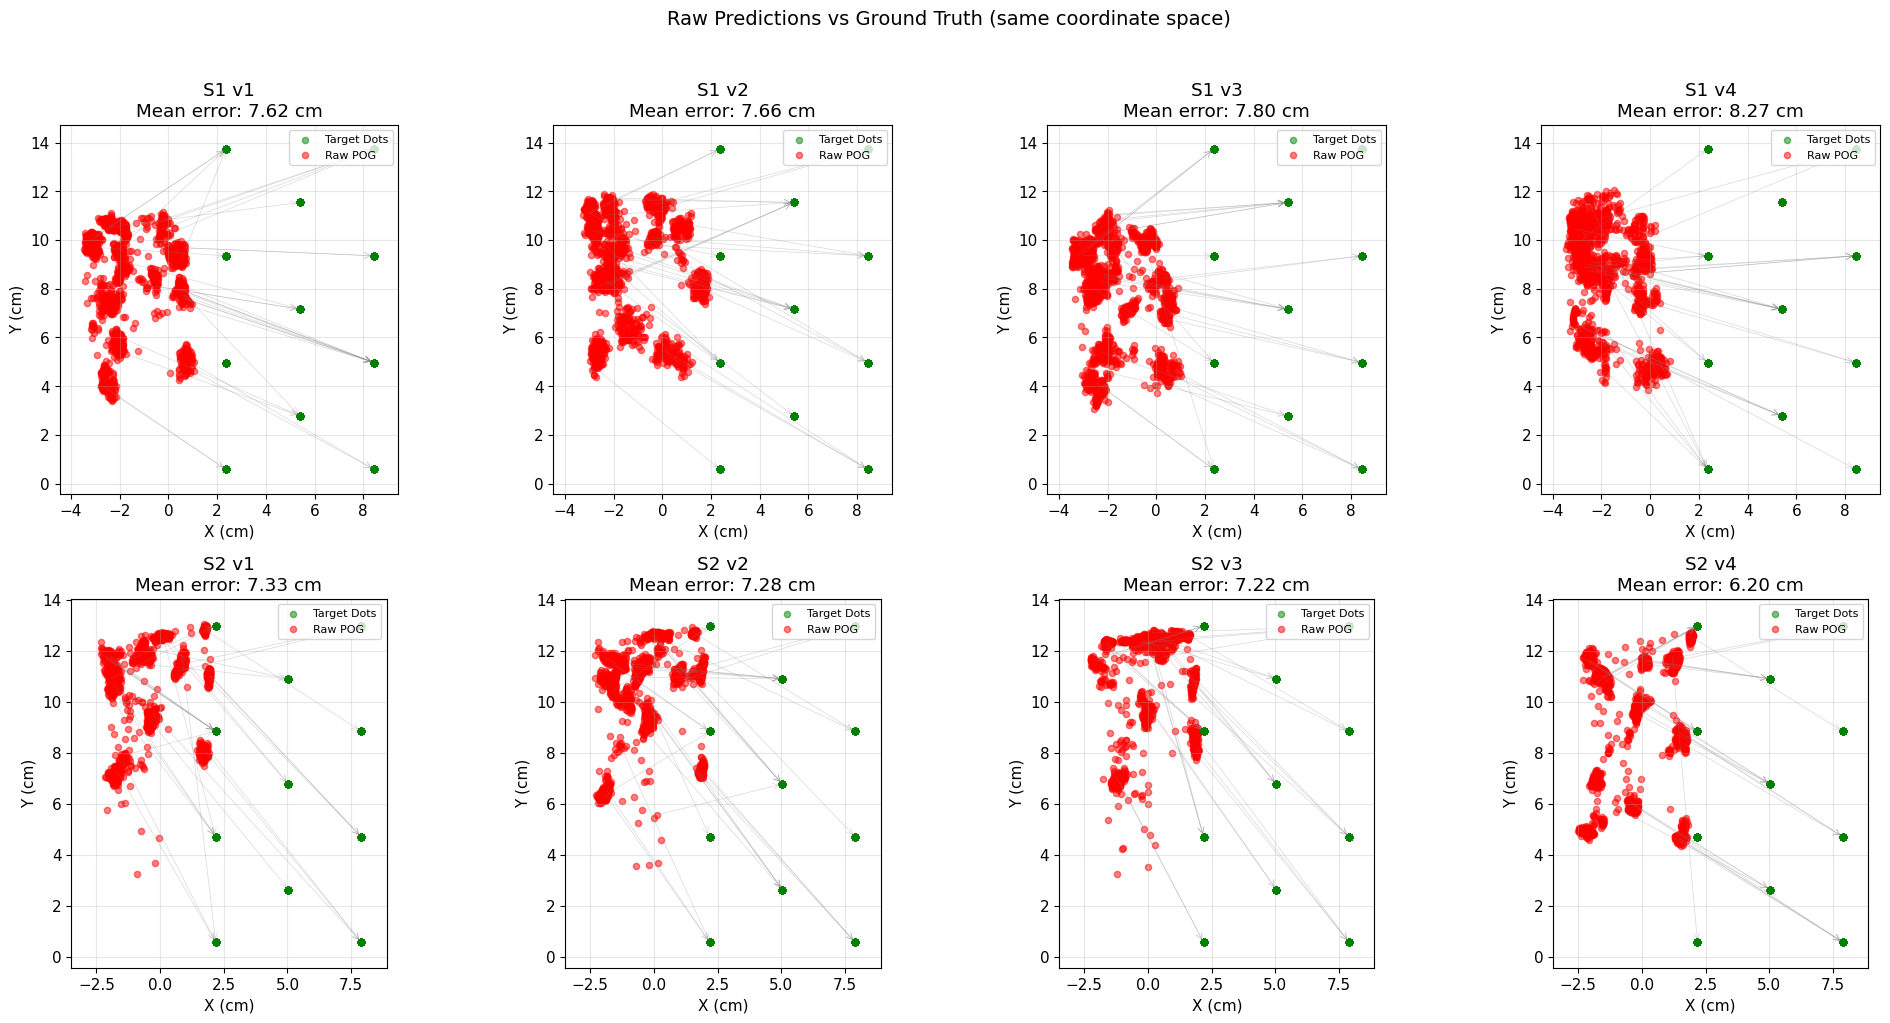

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for row, session in enumerate(['s1', 's2']):
    # Get axis limits that encompass both dots and predictions for this session
    sess_data = calib_valid[calib_valid['session'] == session]
    all_x = np.concatenate([sess_data['dot_x_cm'].values, sess_data['pog_x_cm_new'].values])
    all_y = np.concatenate([sess_data['dot_y_cm'].values, sess_data['pog_y_cm_new'].values])
    x_min, x_max = np.nanmin(all_x) - 1, np.nanmax(all_x) + 1
    y_min, y_max = np.nanmin(all_y) - 1, np.nanmax(all_y) + 1
    
    for col, vid_num in enumerate([1, 2, 3, 4]):
        ax = axes[row, col]
        vid_data = calib_valid[calib_valid['video'] == f'{session}_v{vid_num}']
        
        # Plot with same axis limits for both
        ax.scatter(vid_data['dot_x_cm'], vid_data['dot_y_cm'], c='green', s=20, alpha=0.5, label='Target Dots', zorder=2)
        ax.scatter(vid_data['pog_x_cm_new'], vid_data['pog_y_cm_new'], c='red', s=20, alpha=0.5, label='Raw POG', zorder=1)
        
        # Draw arrows from some predictions to their targets (sample for clarity)
        sample_idx = np.random.choice(len(vid_data), min(30, len(vid_data)), replace=False)
        for i in sample_idx:
            row_data = vid_data.iloc[i]
            ax.annotate('', xy=(row_data['dot_x_cm'], row_data['dot_y_cm']), 
                       xytext=(row_data['pog_x_cm_new'], row_data['pog_y_cm_new']),
                       arrowprops=dict(arrowstyle='->', color='gray', alpha=0.3, lw=0.5))
        
        errors = np.sqrt((vid_data['pog_x_cm_new'] - vid_data['dot_x_cm'])**2 + 
                        (vid_data['pog_y_cm_new'] - vid_data['dot_y_cm'])**2)
        
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_title(f'{session.upper()} v{vid_num}\nMean error: {errors.mean():.2f} cm')
        ax.set_xlabel('X (cm)')
        ax.set_ylabel('Y (cm)')
        ax.legend(fontsize=8, loc='upper right')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)

plt.suptitle('Raw Predictions vs Ground Truth (same coordinate space)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 4. Calibration Method

Using a **linear affine transform** trained on stable frames from a single calibration video.
This produces smooth, well-behaved predictions across the entire screen.

In [7]:
def train_linear_calibration(train_data):
    """Train linear calibration model on stable frames
    
    Uses Ridge regression for a smooth affine transform:
    X_cal = a0 + a1*X_raw + a2*Y_raw
    Y_cal = b0 + b1*X_raw + b2*Y_raw
    """
    train_stable = filter_stable_frames(train_data, keep_ratio=0.5)
    
    X_train = train_stable[['pog_x_cm_new', 'pog_y_cm_new']].values
    y_train = train_stable[['dot_x_cm', 'dot_y_cm']].values
    
    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)
    
    return model, train_stable


def apply_linear_calibration(model, X):
    """Apply linear calibration"""
    return model.predict(X)

## 5. Train Models (Single Video Each)

In [8]:
# Train linear calibration on v1 for each session

# S1: Train on v1
s1_data = calib_valid[calib_valid['session'] == 's1']
s1_train = s1_data[s1_data['video'] == 's1_v1']
s1_model, s1_train_stable = train_linear_calibration(s1_train)
print(f"S1: Trained linear model on {len(s1_train_stable)} stable frames from v1")
print(f"    Coefficients: {s1_model.coef_}")
print(f"    Intercept: {s1_model.intercept_}")

# S2: Train on v1
s2_data = calib_valid[calib_valid['session'] == 's2']
s2_train = s2_data[s2_data['video'] == 's2_v1']
s2_model, s2_train_stable = train_linear_calibration(s2_train)
print(f"\nS2: Trained linear model on {len(s2_train_stable)} stable frames from v1")
print(f"    Coefficients: {s2_model.coef_}")
print(f"    Intercept: {s2_model.intercept_}")

S1: Trained linear model on 834 stable frames from v1
    Coefficients: [[ 1.70472042  0.24226199]
 [-0.28564842  1.96913518]]
    Intercept: [ 5.95448923 -9.13523617]

S2: Trained linear model on 837 stable frames from v1
    Coefficients: [[ 1.57007239  0.07252171]
 [-0.59482468  1.69624603]]
    Intercept: [  4.56203352 -11.37219822]


## 6. Apply Calibration and Evaluate

In [9]:
# Apply linear calibration to all data
calib_valid = calib_valid.copy()

# S1: Apply linear
s1_mask = calib_valid['session'] == 's1'
X_s1 = calib_valid.loc[s1_mask, ['pog_x_cm_new', 'pog_y_cm_new']].values
pred_s1 = apply_linear_calibration(s1_model, X_s1)
calib_valid.loc[s1_mask, 'pog_x_cm_cal'] = pred_s1[:, 0]
calib_valid.loc[s1_mask, 'pog_y_cm_cal'] = pred_s1[:, 1]

# S2: Apply linear
s2_mask = calib_valid['session'] == 's2'
X_s2 = calib_valid.loc[s2_mask, ['pog_x_cm_new', 'pog_y_cm_new']].values
pred_s2 = apply_linear_calibration(s2_model, X_s2)
calib_valid.loc[s2_mask, 'pog_x_cm_cal'] = pred_s2[:, 0]
calib_valid.loc[s2_mask, 'pog_y_cm_cal'] = pred_s2[:, 1]

# Compute errors
calib_valid['error_raw'] = np.sqrt((calib_valid['pog_x_cm_new'] - calib_valid['dot_x_cm'])**2 + 
                                    (calib_valid['pog_y_cm_new'] - calib_valid['dot_y_cm'])**2)
calib_valid['error_cal'] = np.sqrt((calib_valid['pog_x_cm_cal'] - calib_valid['dot_x_cm'])**2 + 
                                    (calib_valid['pog_y_cm_cal'] - calib_valid['dot_y_cm'])**2)

print("\nError Summary:")
summary = calib_valid.groupby('video').agg({
    'error_raw': 'mean',
    'error_cal': 'mean'
}).round(2)
summary['improvement'] = ((summary['error_raw'] - summary['error_cal']) / summary['error_raw'] * 100).round(0).astype(int)
summary.columns = ['Raw (cm)', 'Calibrated (cm)', 'Improvement (%)']
print(summary)


Error Summary:
       Raw (cm)  Calibrated (cm)  Improvement (%)
video                                            
s1_v1      7.62             2.17               72
s1_v2      7.66             2.84               63
s1_v3      7.80             2.50               68
s1_v4      8.27             3.39               59
s2_v1      7.33             2.72               63
s2_v2      7.28             3.05               58
s2_v3      7.22             2.77               62
s2_v4      6.20             3.32               46


## 7. Visualize Calibrated Results

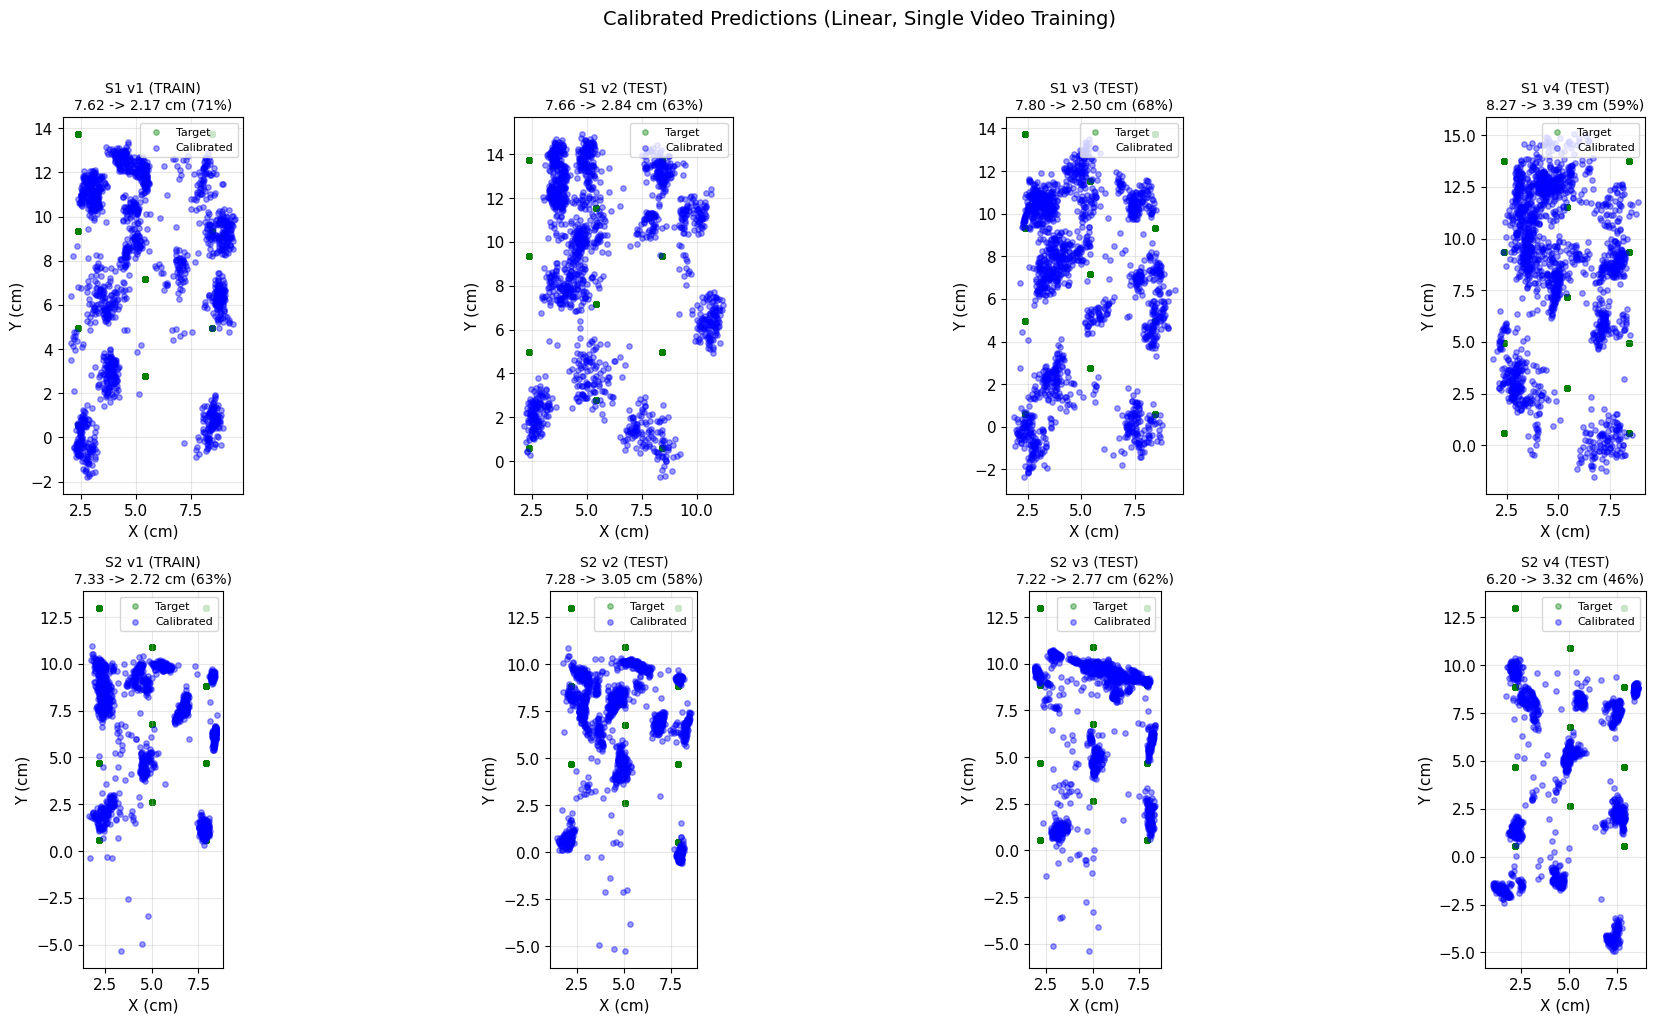

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

train_videos = {'s1': ['s1_v1'], 's2': ['s2_v1']}

for row, session in enumerate(['s1', 's2']):
    for col, vid_num in enumerate([1, 2, 3, 4]):
        ax = axes[row, col]
        vid_key = f'{session}_v{vid_num}'
        vid_data = calib_valid[calib_valid['video'] == vid_key]
        
        ax.scatter(vid_data['dot_x_cm'], vid_data['dot_y_cm'], c='green', s=15, alpha=0.4, label='Target', zorder=1)
        ax.scatter(vid_data['pog_x_cm_cal'], vid_data['pog_y_cm_cal'], c='blue', s=15, alpha=0.4, label='Calibrated', zorder=2)
        
        is_train = vid_key in train_videos[session]
        title = f'{session.upper()} v{vid_num} {"(TRAIN)" if is_train else "(TEST)"}'
        raw_err = vid_data['error_raw'].mean()
        cal_err = vid_data['error_cal'].mean()
        improvement = (raw_err - cal_err) / raw_err * 100
        title += f'\n{raw_err:.2f} -> {cal_err:.2f} cm ({improvement:.0f}%)'
        
        ax.set_title(title, fontsize=10)
        ax.set_xlabel('X (cm)')
        ax.set_ylabel('Y (cm)')
        ax.legend(fontsize=8, loc='upper right')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)

plt.suptitle('Calibrated Predictions (Linear, Single Video Training)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 8. Error Distribution Comparison

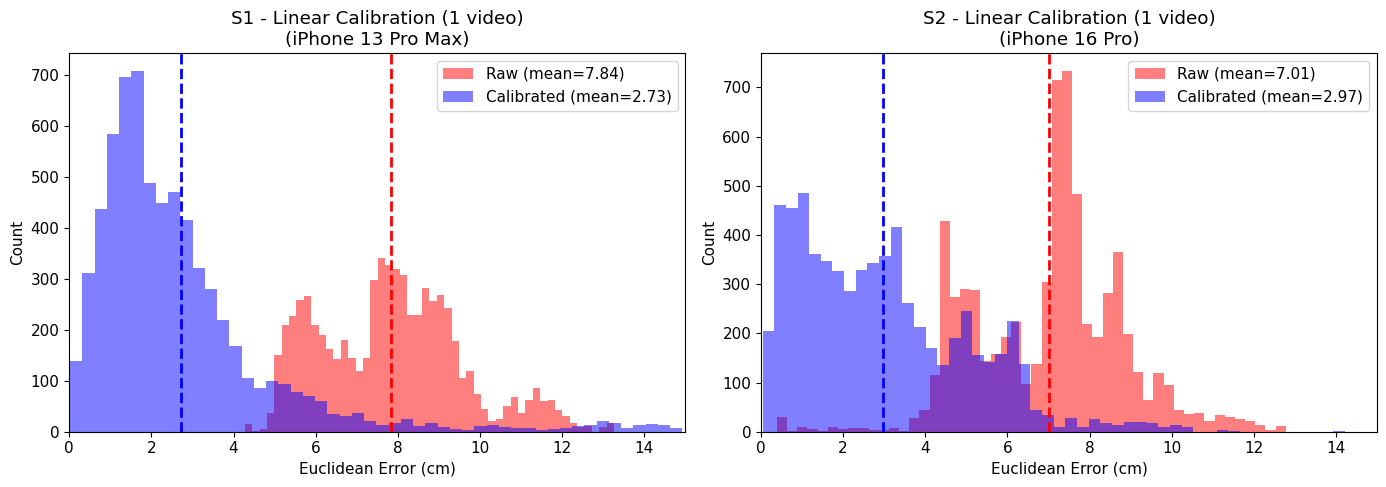

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, session in zip(axes, ['s1', 's2']):
    sess_data = calib_valid[calib_valid['session'] == session]
    
    ax.hist(sess_data['error_raw'], bins=50, alpha=0.5, color='red', 
            label=f'Raw (mean={sess_data["error_raw"].mean():.2f})')
    ax.hist(sess_data['error_cal'], bins=50, alpha=0.5, color='blue', 
            label=f'Calibrated (mean={sess_data["error_cal"].mean():.2f})')
    
    ax.axvline(sess_data['error_raw'].mean(), color='red', linestyle='--', linewidth=2)
    ax.axvline(sess_data['error_cal'].mean(), color='blue', linestyle='--', linewidth=2)
    
    device = device1 if session == 's1' else device2
    ax.set_xlabel('Euclidean Error (cm)')
    ax.set_ylabel('Count')
    ax.set_title(f'{session.upper()} - Linear Calibration (1 video)\n({device})')
    ax.legend()
    ax.set_xlim(0, 15)

plt.tight_layout()
plt.show()

## 9. Per-Dot Error Analysis

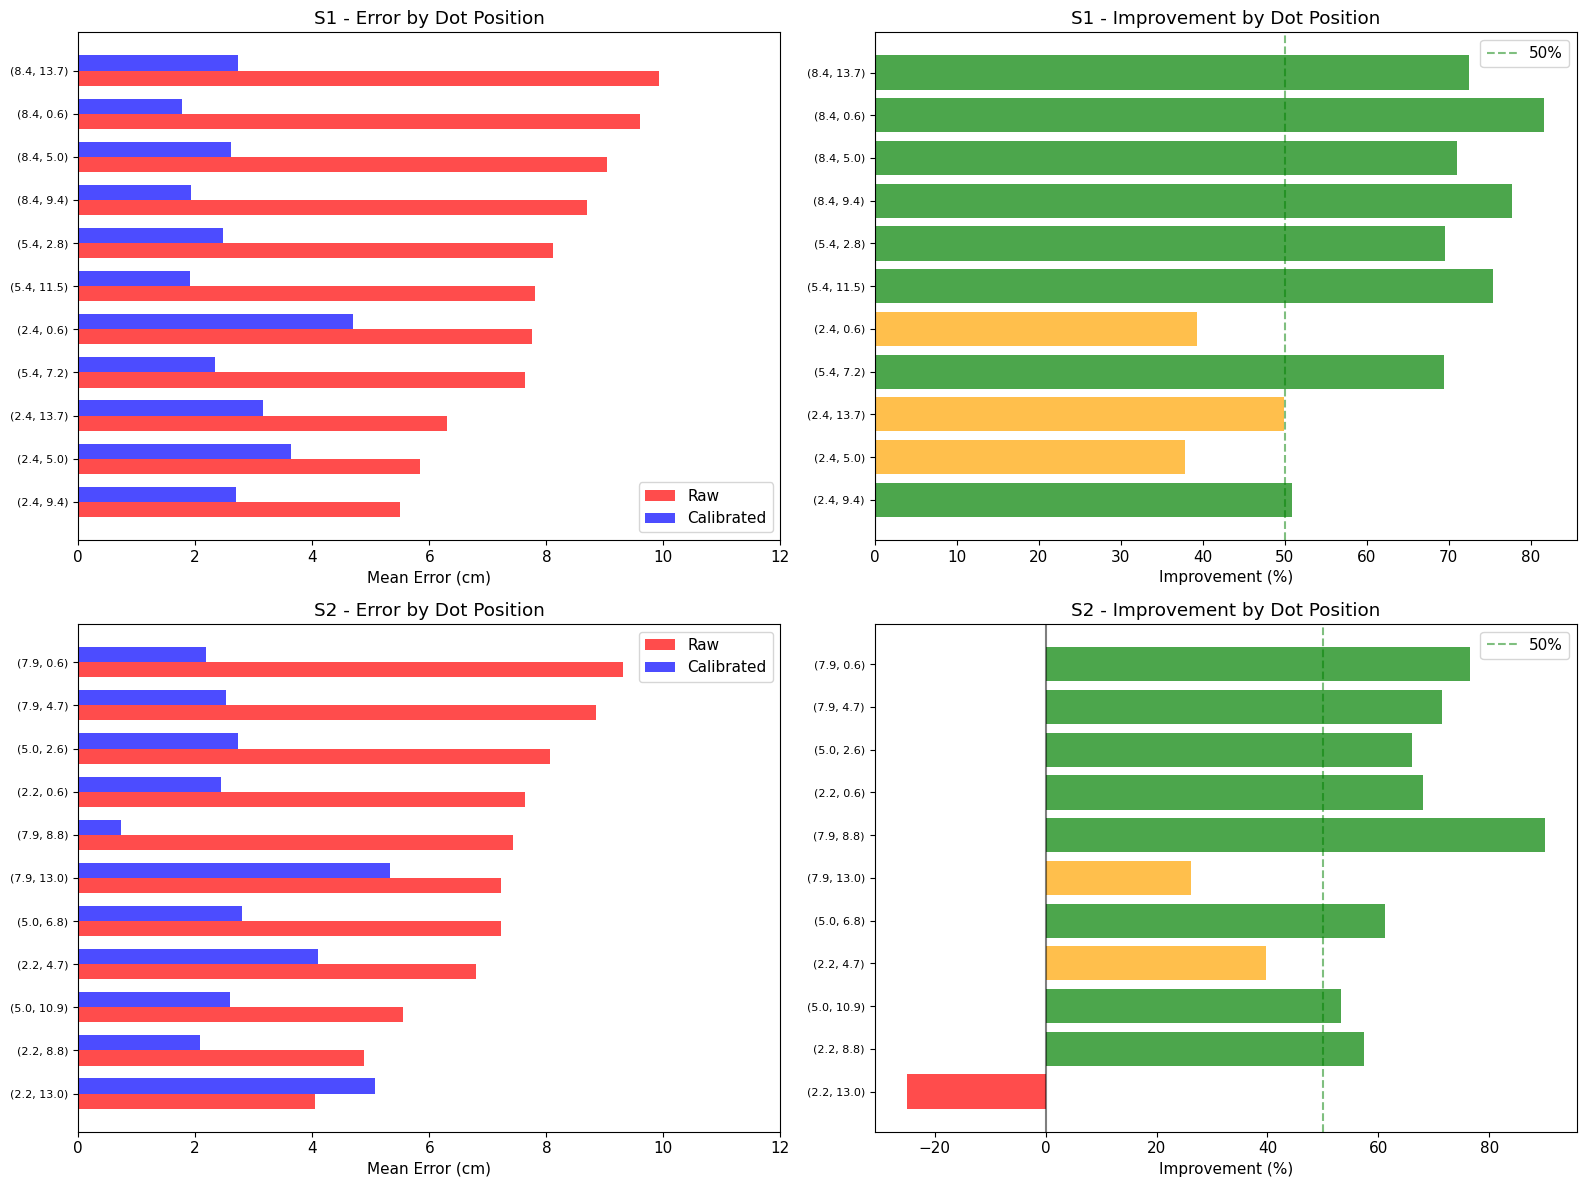

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for row, session in enumerate(['s1', 's2']):
    sess_data = calib_valid[calib_valid['session'] == session].copy()
    sess_data['dot_id'] = sess_data.apply(lambda r: f"({r['dot_x_cm']:.1f}, {r['dot_y_cm']:.1f})", axis=1)
    
    # Raw vs Calibrated by dot
    ax = axes[row, 0]
    dot_errors = sess_data.groupby('dot_id').agg({'error_raw': 'mean', 'error_cal': 'mean'}).sort_values('error_raw')
    x = np.arange(len(dot_errors))
    width = 0.35
    
    bars1 = ax.barh(x - width/2, dot_errors['error_raw'], width, color='red', alpha=0.7, label='Raw')
    bars2 = ax.barh(x + width/2, dot_errors['error_cal'], width, color='blue', alpha=0.7, label='Calibrated')
    
    ax.set_yticks(x)
    ax.set_yticklabels(dot_errors.index, fontsize=8)
    ax.set_xlabel('Mean Error (cm)')
    ax.set_title(f'{session.upper()} - Error by Dot Position')
    ax.legend()
    ax.set_xlim(0, 12)
    
    # Improvement by dot
    ax = axes[row, 1]
    improvements = ((dot_errors['error_raw'] - dot_errors['error_cal']) / dot_errors['error_raw'] * 100)
    colors = ['green' if imp > 50 else 'orange' if imp > 0 else 'red' for imp in improvements]
    ax.barh(x, improvements, color=colors, alpha=0.7)
    ax.set_yticks(x)
    ax.set_yticklabels(dot_errors.index, fontsize=8)
    ax.set_xlabel('Improvement (%)')
    ax.set_title(f'{session.upper()} - Improvement by Dot Position')
    ax.axvline(50, color='green', linestyle='--', alpha=0.5, label='50%')
    ax.axvline(0, color='black', linestyle='-', alpha=0.5)
    ax.legend()

plt.tight_layout()
plt.show()

## 10. Temporal Error Analysis

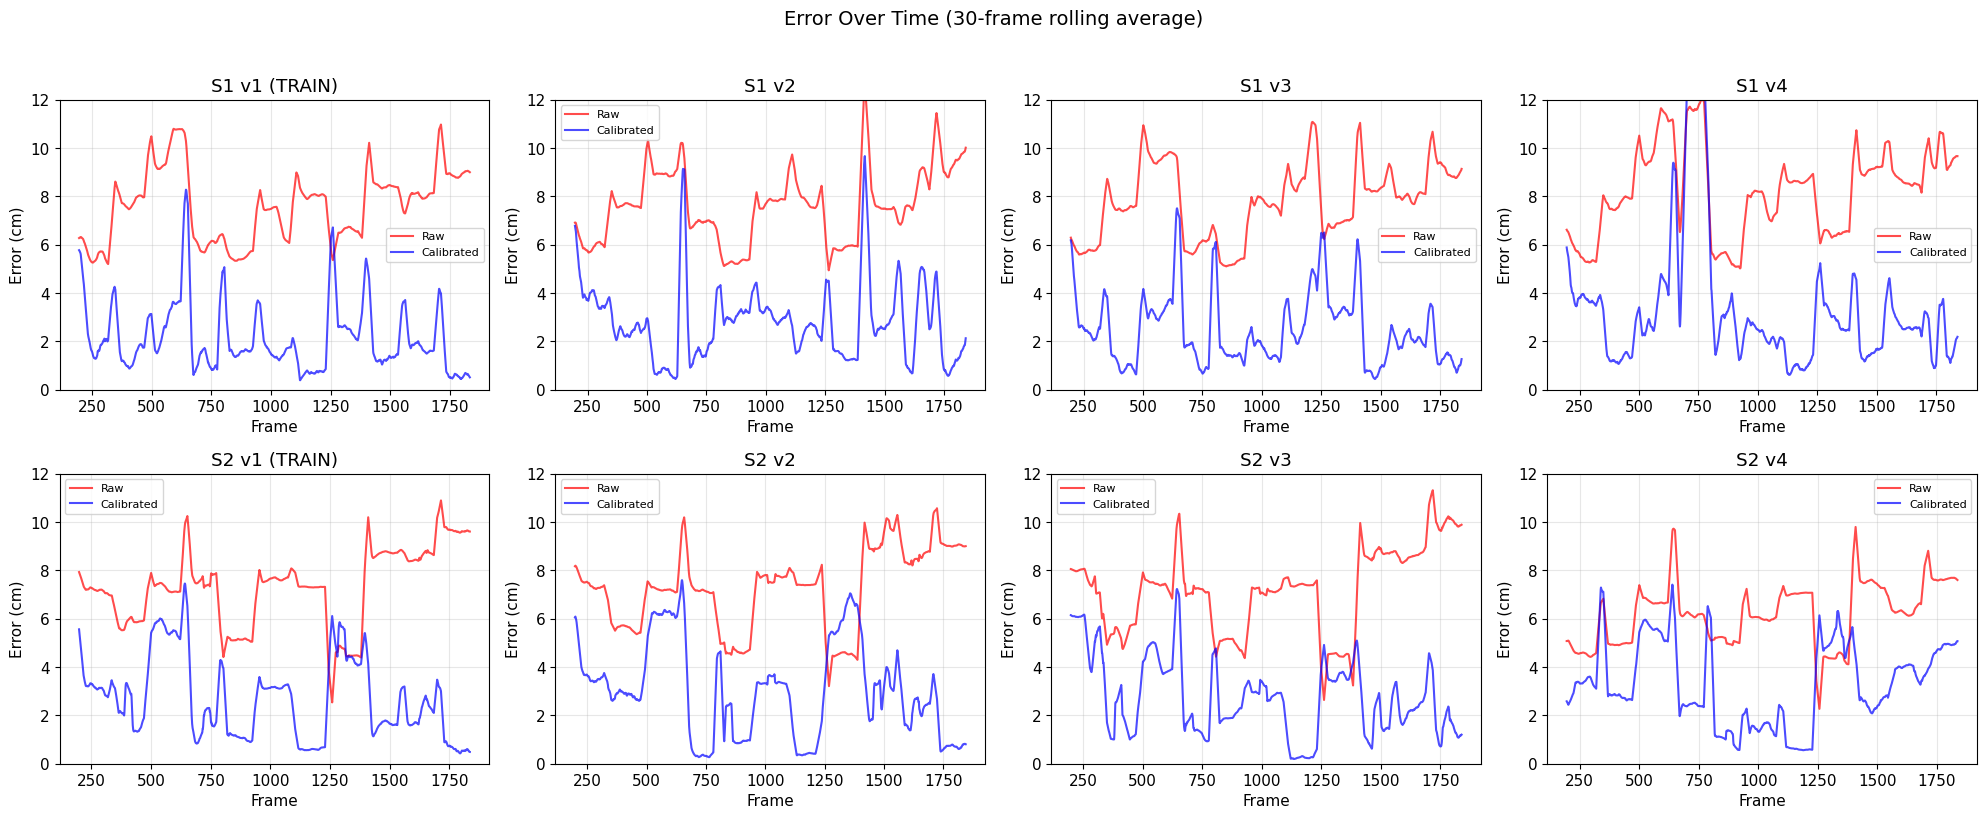

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))

train_videos = {'s1': ['s1_v1'], 's2': ['s2_v1']}  # Single video for each

for row, session in enumerate(['s1', 's2']):
    for col, vid_num in enumerate([1, 2, 3, 4]):
        ax = axes[row, col]
        vid_key = f'{session}_v{vid_num}'
        vid_data = calib_valid[calib_valid['video'] == vid_key].sort_values('frame')
        
        window = 30
        raw_rolling = vid_data['error_raw'].rolling(window, center=True).mean()
        cal_rolling = vid_data['error_cal'].rolling(window, center=True).mean()
        
        ax.plot(vid_data['frame'], raw_rolling, 'r-', alpha=0.7, linewidth=1.5, label='Raw')
        ax.plot(vid_data['frame'], cal_rolling, 'b-', alpha=0.7, linewidth=1.5, label='Calibrated')
        
        is_train = vid_key in train_videos[session]
        title = f'{session.upper()} v{vid_num}'
        if is_train:
            title += ' (TRAIN)'
        ax.set_title(title)
        ax.set_xlabel('Frame')
        ax.set_ylabel('Error (cm)')
        ax.legend(fontsize=8)
        ax.set_ylim(0, 12)
        ax.grid(True, alpha=0.3)

plt.suptitle('Error Over Time (30-frame rolling average)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 11. Summary Statistics

In [14]:
print("="*70)
print("FINAL CALIBRATION SUMMARY")
print("="*70)
print("\nMethod: Linear affine transform (single video training)")

train_vids = {'s1': ['s1_v1'], 's2': ['s2_v1']}

for session in ['s1', 's2']:
    sess_data = calib_valid[calib_valid['session'] == session]
    device = device1 if session == 's1' else device2
    
    print(f"\n{session.upper()} ({device})")
    print(f"Training: {', '.join(train_vids[session])}")
    print("-" * 50)
    
    for vid_num in [1, 2, 3, 4]:
        vid_key = f'{session}_v{vid_num}'
        vid_data = sess_data[sess_data['video'] == vid_key]
        raw_err = vid_data['error_raw'].mean()
        cal_err = vid_data['error_cal'].mean()
        improvement = (raw_err - cal_err) / raw_err * 100
        
        is_train = vid_key in train_vids[session]
        marker = "TRAIN" if is_train else "TEST"
        print(f"  v{vid_num} ({marker:>5}): {raw_err:.2f} -> {cal_err:.2f} cm ({improvement:.0f}% improvement)")
    
    # Only count TEST videos for overall metric
    test_data = sess_data[~sess_data['video'].isin(train_vids[session])]
    test_raw = test_data['error_raw'].mean()
    test_cal = test_data['error_cal'].mean()
    test_improvement = (test_raw - test_cal) / test_raw * 100
    print("-" * 50)
    print(f"  TEST avg: {test_raw:.2f} -> {test_cal:.2f} cm ({test_improvement:.0f}% improvement)")

FINAL CALIBRATION SUMMARY

Method: Linear affine transform (single video training)

S1 (iPhone 13 Pro Max)
Training: s1_v1
--------------------------------------------------
  v1 (TRAIN): 7.62 -> 2.17 cm (71% improvement)
  v2 ( TEST): 7.66 -> 2.84 cm (63% improvement)
  v3 ( TEST): 7.80 -> 2.50 cm (68% improvement)
  v4 ( TEST): 8.27 -> 3.39 cm (59% improvement)
--------------------------------------------------
  TEST avg: 7.91 -> 2.91 cm (63% improvement)

S2 (iPhone 16 Pro)
Training: s2_v1
--------------------------------------------------
  v1 (TRAIN): 7.33 -> 2.72 cm (63% improvement)
  v2 ( TEST): 7.28 -> 3.05 cm (58% improvement)
  v3 ( TEST): 7.22 -> 2.77 cm (62% improvement)
  v4 ( TEST): 6.20 -> 3.32 cm (46% improvement)
--------------------------------------------------
  TEST avg: 6.90 -> 3.05 cm (56% improvement)


## 12. Save Results

In [15]:
# Save calibrated predictions
output_cols = ['video', 'session', 'frame', 'dot_x_cm', 'dot_y_cm',
               'pog_x_cm_new', 'pog_y_cm_new', 'pog_x_cm_cal', 'pog_y_cm_cal',
               'error_raw', 'error_cal']
calib_valid[output_cols].to_parquet('/media/a/saw/pogclaude/calibrated_predictions_best.parquet', index=False)
print("Saved calibrated_predictions_best.parquet")

# Summary CSV
summary = calib_valid.groupby('video').agg({
    'error_raw': ['mean', 'std', 'median'],
    'error_cal': ['mean', 'std', 'median']
}).round(3)
summary.columns = ['raw_mean', 'raw_std', 'raw_median', 'cal_mean', 'cal_std', 'cal_median']
summary['improvement_pct'] = ((summary['raw_mean'] - summary['cal_mean']) / summary['raw_mean'] * 100).round(1)
summary.to_csv('/media/a/saw/pogclaude/calibration_summary_best.csv')
print("Saved calibration_summary_best.csv")
print("\n", summary)

Saved calibrated_predictions_best.parquet
Saved calibration_summary_best.csv

        raw_mean  raw_std  raw_median  cal_mean  cal_std  cal_median  \
video                                                                 
s1_v1     7.620    1.610       7.818     2.174    1.862       1.642   
s1_v2     7.656    1.664       7.601     2.835    2.109       2.530   
s1_v3     7.800    1.665       7.822     2.503    1.924       2.009   
s1_v4     8.273    1.965       8.450     3.388    3.106       2.552   
s2_v1     7.325    1.784       7.411     2.721    1.968       2.099   
s2_v2     7.283    1.796       7.406     3.050    2.212       2.849   
s2_v3     7.221    1.949       7.382     2.769    1.970       2.304   
s2_v4     6.201    1.505       6.189     3.321    2.018       2.995   

       improvement_pct  
video                   
s1_v1             71.5  
s1_v2             63.0  
s1_v3             67.9  
s1_v4             59.0  
s2_v1             62.9  
s2_v2             58.1  
s2_v3     